# Shortcut learning by example of cat vs cow classifier using neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import IPython
import time
import IPython.display as display
from PIL import Image
import cv2

## Data Preparation

In [2]:
cat = np.load('./images/cat.npy')
cow = np.load('./images/cow.npy')

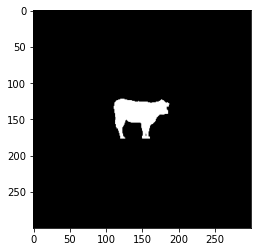

In [3]:
plt.imshow(cow,cmap='gray')

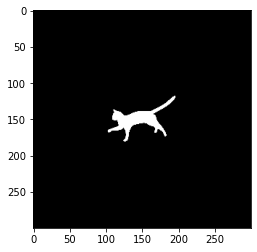

In [4]:
plt.imshow(cat,cmap='gray')

In [5]:
biased_train_cat = []
biased_train_cow = []

for i in range(1000):
  
  x_val = np.random.randint(46,60)
  y_val = np.random.randint(39,70)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cat, translation_matrix, (cat.shape[0], cat.shape[0]))
  biased_train_cat.append(im)
  x_val = np.random.randint(-53,-39)
  y_val = np.random.randint(-65,-34)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cat, translation_matrix, (cat.shape[0], cat.shape[0]))
  biased_train_cat.append(im)

  y_val = np.random.randint(44,64)
  x_val = np.random.randint(-46,-22)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (cat.shape[0], cat.shape[0]))
  biased_train_cow.append(im)
  y_val = np.random.randint(-56,-33)
  x_val = np.random.randint(55,78)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (cat.shape[0], cat.shape[0]))
  biased_train_cow.append(im)

unbiased_train_cat = []
unbiased_train_cow = []

for i in range(2000):
  
  x_val = np.random.randint(-53,60)
  y_val = np.random.randint(-65,70)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cat, translation_matrix, (cat.shape[0], cat.shape[0]))
  unbiased_train_cat.append(im)
  
  y_val = np.random.randint(-56,64)
  x_val = np.random.randint(-46,78)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (cat.shape[0], cat.shape[0]))
  unbiased_train_cow.append(im)
  
biased_train_cow = np.array(biased_train_cow)
biased_train_cat = np.array(biased_train_cat)
unbiased_train_cow = np.array(unbiased_train_cow)
unbiased_train_cat = np.array(unbiased_train_cat)

## Bundle train and test data

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time
from sklearn.model_selection import train_test_split

In [7]:
# cats are 0 and cows are 1
# generate test data
X_unbiased = np.concatenate((unbiased_train_cat, unbiased_train_cow))
X_unbiased = X_unbiased.reshape(X_unbiased.shape[0], X_unbiased.shape[1], X_unbiased.shape[2], 1)

y = np.concatenate((np.zeros(len(unbiased_train_cat)),np.ones(len(unbiased_train_cow))))
y = y.reshape(len(y), 1)

# generate train data
X_biased = np.concatenate((biased_train_cat,biased_train_cow))
X_biased = X_biased.reshape(X_biased.shape[0], X_biased.shape[1], X_biased.shape[2], 1)

# split up biased data into train and i.i.d. test data
X_biased_train, X_biased_test, y_biased_train, y_biased_test = train_test_split(X_biased, y, test_size=0.25, random_state=1)
X_unbiased_train, X_unbiased_test, y_unbiased_train, y_unbiased_test = train_test_split(X_unbiased, y, test_size=0.25, random_state=1)
test_unbiased = tf.data.Dataset.from_tensor_slices((X_unbiased, y))
training_biased = tf.data.Dataset.from_tensor_slices((X_biased_train, y_biased_train))
test_biased = tf.data.Dataset.from_tensor_slices((X_biased_test, y_biased_test))
training_unbiased = tf.data.Dataset.from_tensor_slices((X_unbiased_train, y_unbiased_train))

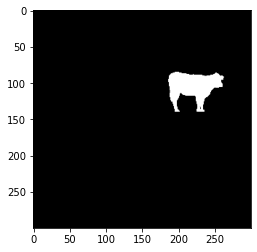

In [8]:
plt.imshow(X_biased[3001], cmap='gray')

### Visualize biased data

In [9]:
def visualize_samples(data):
  class_types = ["cat", "cow"]
  check_list = list(data.as_numpy_iterator())

  fig = plt.figure(figsize=(8,8))
  for i in range(25, 50):
    plt.subplot(5,5,(i-25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(check_list[i][0], cmap='gray')
    plt.xlabel(class_types [int(check_list[i][1][0])], fontsize=13)
  plt.tight_layout()
  plt.show()

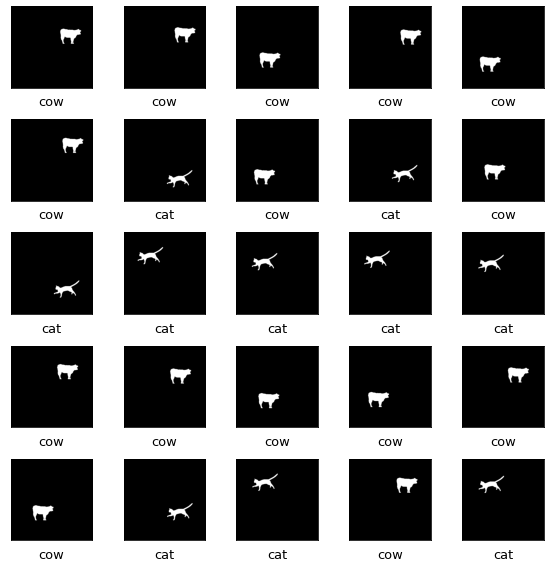

In [10]:
visualize_samples(training_biased)

### Visualize unbiased data

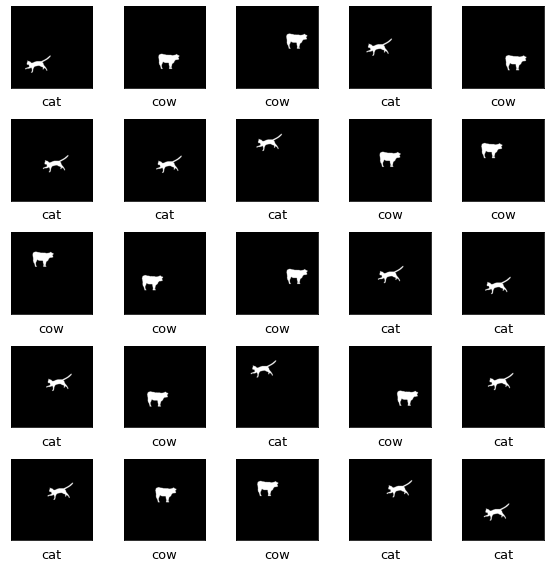

In [11]:
visualize_samples(test_unbiased.shuffle(buffer_size=len(y)))

### Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

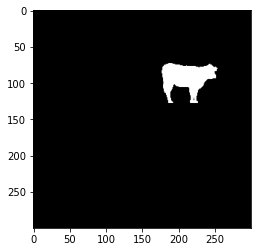

In [13]:
plt.imshow(X_biased_train[0], cmap="gray")

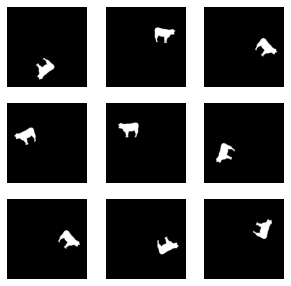

In [14]:
for image, _ in training_biased.take(1):
    plt.figure(figsize=(5, 5))
    first_image = image
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0], cmap="gray")
        plt.axis('off')

## Build an ANN net with tensorflow

### Train fully connected ANN with 4 hidden layers and one output layer

In [15]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , AvgPool2D, Flatten, Dropout

In [16]:
def dnn_model(data = training_biased, 
            fit = False, regularization = False,
            load = True, epochs = 5, augmentation = False, save = True):
    
    data = data.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # define callback options
    dnn_checkpoint_path = "dnn_checkpoints/dnn"
    if regularization:
        dnn_checkpoint_path = dnn_checkpoint_path + "_reg"
    if augmentation:
        dnn_checkpoint_path = dnn_checkpoint_path + "_aug"
    dnn_checkpoint_path = dnn_checkpoint_path + ".ckpt"

    if save:
        # Create a callback that saves the model's weights
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=dnn_checkpoint_path,
                                                        save_weights_only=True,
                                                        verbose=1)

    # define model
    if augmentation:
        dnn = Sequential([data_augmentation])
    else:
        dnn = Sequential()
    dnn.add(Flatten())
    dnn.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    if regularization:
        dnn.add(Dropout(0.2))
    dnn.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    if regularization:
        dnn.add(Dropout(0.2))
    dnn.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    if regularization:
        dnn.add(Dropout(0.2))
    dnn.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
    if regularization:
        dnn.add(Dropout(0.2))
    dnn.add(Dense(1, activation='sigmoid'))
    # # compile the model
    opt = keras.optimizers.Adam(learning_rate=0.001)
    dnn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    # # fit the model
    if fit:
        if save:
            dnn.fit(data,
                epochs=epochs,
                callbacks=[cp_callback])
        else:
            dnn.fit(data, epochs=epochs)
    elif load:
        dnn.load_weights(dnn_checkpoint_path)
    
    return dnn

#### Not augmented data

In [17]:
print("### Training normal DNN ###")
dnn = dnn_model(fit = True, epochs = 2, save = False, load = False)
print("### Training normal DNN with dropout ###")
dnn_dropout = dnn_model(fit = True, epochs = 2, regularization=True, save = False, load = False)

print(dnn.summary())

### Training normal DNN ###
Epoch 1/2
24/24 [==============================] - 5s 164ms/step - loss: 0.0299 - accuracy: 0.9757
Epoch 2/2
24/24 [==============================] - 4s 169ms/step - loss: 3.6263e-09 - accuracy: 1.0000
### Training normal DNN with dropout ###
Epoch 1/2
24/24 [==============================] - 5s 166ms/step - loss: 0.0353 - accuracy: 0.9783
Epoch 2/2
24/24 [==============================] - 4s 166ms/step - loss: 2.5608e-04 - accuracy: 0.9997
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense (Dense)               (None, 512)               46080512  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                           

#### Augmented Data

In [18]:
print("### Training normal DNN with augmentation ###")
dnn_aug = dnn_model(fit = True, save = False, load = False, epochs = 10, augmentation = True)
print("### Training normal DNN with dropout and augmentation ###")
dnn_dropout_aug = dnn_model(fit = True, save = False, load = False, regularization=True, epochs = 10, augmentation = True)

### Training normal DNN with augmentation ###
Epoch 1/10
24/24 [==============================] - 8s 251ms/step - loss: 0.5590 - accuracy: 0.7180
Epoch 2/10
24/24 [==============================] - 6s 247ms/step - loss: 0.1772 - accuracy: 0.9323
Epoch 3/10
24/24 [==============================] - 6s 247ms/step - loss: 0.1326 - accuracy: 0.9510
Epoch 4/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0662 - accuracy: 0.9770
Epoch 5/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0673 - accuracy: 0.9773
Epoch 6/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0361 - accuracy: 0.9880
Epoch 7/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0387 - accuracy: 0.9870
Epoch 8/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0122 - accuracy: 0.9950
Epoch 9/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0174 - accuracy: 0.9940
Epoch 10/10
24/24 [==============================] - 6

In [20]:
print("### Training normal DNN with dropout and augmentation and unbiased training data ###")
dnn_unbiased_dropout_aug = dnn_model(fit = True, save = False, load = False, 
                                    data = training_unbiased, regularization=True, 
                                    epochs = 5, augmentation = False)

### Training normal DNN with dropout and augmentation and unbiased training data ###
Epoch 1/5
24/24 [==============================] - 5s 170ms/step - loss: 0.8897 - accuracy: 0.5960
Epoch 2/5
24/24 [==============================] - 4s 170ms/step - loss: 0.5967 - accuracy: 0.6890
Epoch 3/5
24/24 [==============================] - 4s 173ms/step - loss: 0.3705 - accuracy: 0.8233
Epoch 4/5
24/24 [==============================] - 4s 168ms/step - loss: 0.1929 - accuracy: 0.9280
Epoch 5/5
24/24 [==============================] - 4s 172ms/step - loss: 0.0791 - accuracy: 0.9710


### Evaluation

#### No Augmentatioin

In [21]:
def model_evaluation(X_test = X_biased_test, y_test = y_biased_test, biased = True, model = dnn):
    if biased:
        loss, acc = model.evaluate(X_test, y_test)
        print('Test Accuracy on biased i.i.d. test data: %.3f' % acc)
    else:
        loss, acc = model.evaluate(X_unbiased, y)
        print('Test Accuracy on unbiased o.o.d. test data: %.3f' % acc)


In [22]:
print("### without dropout ###")
model_evaluation(model = dnn)
model_evaluation(model = dnn, biased = False)
print("### with dropout")
model_evaluation(model = dnn_dropout)
model_evaluation(model = dnn_dropout, biased = False)

### without dropout ###
32/32 [==============================] - 1s 24ms/step - loss: 9.7615e-09 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 3s 24ms/step - loss: 22.4117 - accuracy: 0.4857
Test Accuracy on unbiased o.o.d. test data: 0.486
### with dropout
32/32 [==============================] - 1s 24ms/step - loss: 1.7117e-26 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 3s 24ms/step - loss: 19.6230 - accuracy: 0.4933
Test Accuracy on unbiased o.o.d. test data: 0.493


**Perfect result: Based on a normal train/test split we achieve a perfect accuracy-score** <br/>
**Based on o.o.d. test data the model performs similar to random guessing**

#### Augmentation

In [23]:
print("### without dropout ###")
model_evaluation(model = dnn_aug)
model_evaluation(model = dnn_aug, biased = False)
print("### with dropout")
model_evaluation(model = dnn_dropout_aug)
model_evaluation(model = dnn_dropout_aug, biased = False)

### without dropout ###
32/32 [==============================] - 1s 23ms/step - loss: 0.0139 - accuracy: 0.9930
Test Accuracy on biased i.i.d. test data: 0.993
125/125 [==============================] - 3s 24ms/step - loss: 2.5080 - accuracy: 0.6825
Test Accuracy on unbiased o.o.d. test data: 0.683
### with dropout
32/32 [==============================] - 1s 23ms/step - loss: 0.0045 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 3s 26ms/step - loss: 2.9719 - accuracy: 0.6478
Test Accuracy on unbiased o.o.d. test data: 0.648


In [24]:
print("### with dropout on unbiased")
model_evaluation(X_test = X_unbiased_test, y_test = y_unbiased_test, model = dnn_unbiased_dropout_aug, biased = False)

### with dropout on unbiased
125/125 [==============================] - 3s 22ms/step - loss: 0.0268 - accuracy: 0.9935
Test Accuracy on unbiased o.o.d. test data: 0.993


## Build 1 block VGG in tensorflow

### Define architectures

In [38]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         # in_channels, out_channels, kernel_size, stride
#         self.c1 = nn.Conv2d(1, 32, 5, 1, padding=2)
#         self.c2 = nn.Conv2d(32, 32, 5, 1, padding=2)
#         self.c3 = nn.Conv2d(32, 32, 5, 1, padding=2)
#         self.pool = nn.AvgPool2d(200)
#         self.fc = nn.Linear(32, 2)
#     def forward(self, x):
#         x = F.relu(self.c1(x))
#         x = F.relu(self.c2(x))
#         x = F.relu(self.c3(x))
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

def geirhos_architecture(data = training_biased):
    data = data.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    geirhos_cnn = Sequential()
    geirhos_cnn.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(300, 300, 1)))
    geirhos_cnn.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
    geirhos_cnn.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
    geirhos_cnn.add(AvgPool2D(pool_size=(300,300)))
    
    geirhos_cnn.add(Flatten())
    geirhos_cnn.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    geirhos_cnn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    geirhos_cnn.fit(data, epochs=5)

    return geirhos_cnn
    

In [ ]:
geirhos_cnn = geirhos_architecture()

Epoch 1/5
 1/24 [>.............................] - ETA: 4:22 - loss: 0.6991 - accuracy: 0.4766

In [29]:
def model_evaluation(X_test = X_biased_test, y_test = y_biased_test, biased = True, model = geirhos_cnn):
    if biased:
        loss, acc = model.evaluate(X_test, y_test)
        print('Test Accuracy on biased i.i.d. test data: %.3f' % acc)
    else:
        loss, acc = model.evaluate(X_unbiased, y)
        print('Test Accuracy on unbiased o.o.d. test data: %.3f' % acc)

NameError: name 'geirhos_cnn' is not defined

In [30]:
print("### Geirhos CNN evaluation ###")
model_evaluation(model = geirhos_cnn)
model_evaluation(model = geirhos_cnn, biased = False)

### Geirhos CNN evaluation ###


NameError: name 'geirhos_cnn' is not defined

In [31]:
def vgg_x(data = training_biased, 
		blocks = 1, fit = False, load = True,
		epochs = 5, regularization = False, 
		augmentation = False, save = True):
	
	data = data.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
	# Create a callback that saves the model's weights
	vggx_checkpoint_path = "dnn_checkpoints/dnn"
	if regularization:
		vggx_checkpoint_path = vggx_checkpoint_path + "_reg"
	if augmentation:
		vggx_checkpoint_path = vggx_checkpoint_path + "_aug"
	vggx_checkpoint_path = vggx_checkpoint_path + ".ckpt"
	
	cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=vggx_checkpoint_path,
													save_weights_only=True,
													verbose=1)

	if augmentation:
		vgg = Sequential([data_augmentation])
	else:
		vgg = Sequential()
	
	vgg.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(300, 300, 1)))
	vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

	if regularization:
		print("### Dropout 1 ###")
		vgg.add(Dropout(0.2))

	if blocks > 1:
		print("### ConvBlock 2 ###")
		vgg.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
		vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

		if regularization:
			print("### Dropout 2 ###")
			vgg.add(Dropout(0.2))
	
	if blocks > 2:
		print("### ConvBlock 3 ###")
		vgg.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
		vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
		
		if regularization:
			print("### Dropout 3 ###")
			vgg.add(Dropout(0.2))

	########## remains the same for all VGG architectures ##########
	vgg.add(Flatten())
	vgg.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

	if regularization:
		print("### Dropout 4 ###")
		vgg.add(Dropout(0.5))
	
	vgg.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = tf.keras.optimizers.Adam(learning_rate=0.001)
	vgg.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

	if fit:
		if save:
			vgg.fit(data, epochs=epochs, callbacks=[cp_callback])
		else:
			vgg.fit(data, epochs=epochs)
	elif load:
		vgg.load_weights(vggx_checkpoint_path)

	return vgg

### VGG1

In [32]:
vgg1 = vgg_x(fit = True, save = False, blocks = 1, epochs = 2)
vgg1_dropout = vgg_x(fit = True, save = False, blocks = 1, regularization = True, epochs = 2)

print(vgg1.summary())

Epoch 1/2
24/24 [==============================] - 29s 1s/step - loss: 0.0291 - accuracy: 0.9803
Epoch 2/2
24/24 [==============================] - 28s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
### Dropout 1 ###
### Dropout 4 ###
Epoch 1/2
24/24 [==============================] - 39s 2s/step - loss: 0.0282 - accuracy: 0.9820
Epoch 2/2
24/24 [==============================] - 38s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 300, 300, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 flatten_7 (Flatten)         (None, 720000)            0         
                  

In [26]:
print("### without dropout ###")
model_evaluation(model = vgg1)
model_evaluation(model = vgg1, biased = False)
print("### with dropout")
model_evaluation(model = vgg1_dropout)
model_evaluation(model = vgg1_dropout, biased = False)

### without dropout ###
32/32 [==============================] - 3s 88ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 11s 90ms/step - loss: 64.4110 - accuracy: 0.4863
Test Accuracy on unbiased o.o.d. test data: 0.486
### with dropout
32/32 [==============================] - 3s 89ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 11s 90ms/step - loss: 92.6989 - accuracy: 0.4832
Test Accuracy on unbiased o.o.d. test data: 0.483


In [27]:
vgg1_aug = vgg_x(fit = True, save = False, blocks = 1, augmentation = True, epochs = 12)
vgg1_dropout_aug = vgg_x(fit = True, save = False, blocks = 1, regularization = True, augmentation = True, epochs = 12)

Epoch 1/12
24/24 [==============================] - 37s 1s/step - loss: 0.7605 - accuracy: 0.7817
Epoch 2/12
24/24 [==============================] - 35s 1s/step - loss: 0.0430 - accuracy: 0.9907
Epoch 3/12
24/24 [==============================] - 33s 1s/step - loss: 0.0066 - accuracy: 0.9987
Epoch 4/12
24/24 [==============================] - 35s 1s/step - loss: 0.0038 - accuracy: 0.9993
Epoch 5/12
24/24 [==============================] - 35s 1s/step - loss: 0.0015 - accuracy: 1.0000
Epoch 6/12
24/24 [==============================] - 35s 1s/step - loss: 7.2121e-04 - accuracy: 1.0000
Epoch 7/12
24/24 [==============================] - 35s 1s/step - loss: 7.1179e-04 - accuracy: 1.0000
Epoch 8/12
24/24 [==============================] - 35s 1s/step - loss: 3.1311e-04 - accuracy: 1.0000
Epoch 9/12
24/24 [==============================] - 35s 1s/step - loss: 2.6083e-04 - accuracy: 1.0000
Epoch 10/12
24/24 [==============================] - 35s 1s/step - loss: 2.3377e-04 - accuracy: 1.0000

In [28]:
print("### without dropout ###")
model_evaluation(model = vgg1_aug)
model_evaluation(model = vgg1_aug, biased = False)
print("### with dropout")
model_evaluation(model = vgg1_dropout_aug)
model_evaluation(model = vgg1_dropout_aug, biased = False)

### without dropout ###
32/32 [==============================] - 3s 91ms/step - loss: 1.8551e-04 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 12s 95ms/step - loss: 2.5628 - accuracy: 0.7715
Test Accuracy on unbiased o.o.d. test data: 0.771
### with dropout
32/32 [==============================] - 3s 97ms/step - loss: 5.6559e-05 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 12s 97ms/step - loss: 2.1914 - accuracy: 0.7897
Test Accuracy on unbiased o.o.d. test data: 0.790


### VGG2

In [29]:
vgg2 = vgg_x(fit = True, save = False, blocks = 2, epochs = 2)
vgg2_dropout = vgg_x(fit = True, save = False, blocks = 2, regularization = True, epochs = 2)

print(vgg2.summary())

### ConvBlock 2 ###
Epoch 1/2
24/24 [==============================] - 71s 3s/step - loss: 0.0316 - accuracy: 0.9687
Epoch 2/2
24/24 [==============================] - 70s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000
### Dropout 1 ###
### ConvBlock 2 ###
### Dropout 2 ###
### Dropout 4 ###
Epoch 1/2
24/24 [==============================] - 84s 3s/step - loss: 0.0266 - accuracy: 0.9830
Epoch 2/2
24/24 [==============================] - 83s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 300, 300, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)       

In [38]:
print(vgg2.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 300, 300, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 360000)            0         
                                                                 
 dense_33 (Dense)            (None, 128)             

In [30]:
print("### without dropout ###")
model_evaluation(model = vgg2)
model_evaluation(model = vgg2, biased = False)
print("### with dropout")
model_evaluation(model = vgg2_dropout)
model_evaluation(model = vgg2_dropout, biased = False)

### without dropout ###
32/32 [==============================] - 5s 150ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 20s 159ms/step - loss: 50.2618 - accuracy: 0.4850
Test Accuracy on unbiased o.o.d. test data: 0.485
### with dropout
32/32 [==============================] - 5s 156ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 19s 155ms/step - loss: 57.0987 - accuracy: 0.4845
Test Accuracy on unbiased o.o.d. test data: 0.484


In [31]:
vgg2_aug = vgg_x(fit = True, save = False, blocks = 2, augmentation = True, epochs = 10)
vgg2_dropout_aug = vgg_x(fit = True, save = False, blocks = 2, regularization = True, augmentation = True, epochs = 10)

### ConvBlock 2 ###
Epoch 1/10
24/24 [==============================] - 73s 3s/step - loss: 0.8509 - accuracy: 0.7717
Epoch 2/10
24/24 [==============================] - 76s 3s/step - loss: 0.0572 - accuracy: 0.9910
Epoch 3/10
24/24 [==============================] - 72s 3s/step - loss: 0.0050 - accuracy: 0.9993
Epoch 4/10
24/24 [==============================] - 72s 3s/step - loss: 0.0022 - accuracy: 0.9997
Epoch 5/10
24/24 [==============================] - 70s 3s/step - loss: 0.0020 - accuracy: 0.9997
Epoch 6/10
24/24 [==============================] - 69s 3s/step - loss: 0.0035 - accuracy: 0.9993
Epoch 7/10
24/24 [==============================] - 69s 3s/step - loss: 0.0015 - accuracy: 0.9997
Epoch 8/10
24/24 [==============================] - 69s 3s/step - loss: 5.3109e-04 - accuracy: 1.0000
Epoch 9/10
24/24 [==============================] - 69s 3s/step - loss: 5.3407e-04 - accuracy: 1.0000
Epoch 10/10
24/24 [==============================] - 69s 3s/step - loss: 3.3833e-04 - accu

In [32]:
print("### without dropout ###")
model_evaluation(model = vgg2_aug)
model_evaluation(model = vgg2_aug, biased = False)
print("### with dropout")
model_evaluation(model = vgg2_dropout_aug)
model_evaluation(model = vgg2_dropout_aug, biased = False)

### without dropout ###
32/32 [==============================] - 6s 170ms/step - loss: 6.5998e-04 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 21s 171ms/step - loss: 2.7267 - accuracy: 0.7067
Test Accuracy on unbiased o.o.d. test data: 0.707
### with dropout
32/32 [==============================] - 6s 177ms/step - loss: 0.0042 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 22s 175ms/step - loss: 1.7211 - accuracy: 0.7500
Test Accuracy on unbiased o.o.d. test data: 0.750


### VGG3

In [33]:
vgg3 = vgg_x(fit = True, save = False, blocks = 3, epochs = 2)
vgg3_dropout = vgg_x(fit = True, save = False, blocks = 3, regularization = True, epochs = 2)

print(vgg3.summary())

### ConvBlock 2 ###
### ConvBlock 3 ###
Epoch 1/2
24/24 [==============================] - 102s 4s/step - loss: 0.0270 - accuracy: 0.9797
Epoch 2/2
24/24 [==============================] - 99s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000
### Dropout 1 ###
### ConvBlock 2 ###
### Dropout 2 ###
### ConvBlock 3 ###
### Dropout 3 ###
### Dropout 4 ###
Epoch 1/2
24/24 [==============================] - 115s 5s/step - loss: 0.0375 - accuracy: 0.9777
Epoch 2/2
24/24 [==============================] - 113s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 300, 300, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 150, 150, 32)     0         
 g2D)                                                            
                              

In [39]:
print(vgg3.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 300, 300, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 150, 150, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 37, 37, 128)    

In [34]:
print("### without dropout ###")
model_evaluation(model = vgg3)
model_evaluation(model = vgg3, biased = False)
print("### with dropout")
model_evaluation(model = vgg3_dropout)
model_evaluation(model = vgg3_dropout, biased = False)

### without dropout ###
32/32 [==============================] - 6s 198ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 26s 205ms/step - loss: 84.7500 - accuracy: 0.4827
Test Accuracy on unbiased o.o.d. test data: 0.483
### with dropout
32/32 [==============================] - 7s 209ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 26s 207ms/step - loss: 51.2252 - accuracy: 0.4825
Test Accuracy on unbiased o.o.d. test data: 0.482


In [35]:
vgg3_aug = vgg_x(fit = True, save = False, blocks = 3, augmentation = True, epochs = 10)
vgg3_dropout_aug = vgg_x(fit = True, save = False, blocks = 3, regularization = True, augmentation = True, epochs = 10)

### ConvBlock 2 ###
### ConvBlock 3 ###
Epoch 1/10
24/24 [==============================] - 100s 4s/step - loss: 0.6315 - accuracy: 0.8163
Epoch 2/10
24/24 [==============================] - 99s 4s/step - loss: 0.0201 - accuracy: 0.9913
Epoch 3/10
24/24 [==============================] - 99s 4s/step - loss: 0.0025 - accuracy: 0.9990
Epoch 4/10
24/24 [==============================] - 99s 4s/step - loss: 0.0012 - accuracy: 0.9997
Epoch 5/10
24/24 [==============================] - 99s 4s/step - loss: 3.7659e-04 - accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 99s 4s/step - loss: 0.0012 - accuracy: 0.9997
Epoch 7/10
24/24 [==============================] - 99s 4s/step - loss: 3.3038e-04 - accuracy: 1.0000
Epoch 8/10
24/24 [==============================] - 99s 4s/step - loss: 2.3767e-04 - accuracy: 1.0000
Epoch 9/10
24/24 [==============================] - 99s 4s/step - loss: 7.7948e-05 - accuracy: 1.0000
Epoch 10/10
24/24 [==============================] - 100s 4s/

In [36]:
print("### without dropout ###")
model_evaluation(model = vgg3_aug)
model_evaluation(model = vgg3_aug, biased = False)
print("### with dropout")
model_evaluation(model = vgg3_dropout_aug)
model_evaluation(model = vgg3_dropout_aug, biased = False)

### without dropout ###
32/32 [==============================] - 7s 224ms/step - loss: 4.3597e-05 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 27s 220ms/step - loss: 4.5555 - accuracy: 0.6708
Test Accuracy on unbiased o.o.d. test data: 0.671
### with dropout
32/32 [==============================] - 7s 217ms/step - loss: 7.9481e-04 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 29s 229ms/step - loss: 4.6141 - accuracy: 0.6363
Test Accuracy on unbiased o.o.d. test data: 0.636
